# 기계학습 특강 (8주차) 10월26일--(1)
> 이미지자료분석 - CNN 다중클래스 분류, fastai metric 사용 

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Special Topics in Machine Learning, 이미지자료분석, CNN 다중클래스분류, fastai metric]

## imports 

In [1]:
import torch 
import torchvision
import numpy as np
from fastai.vision.all import * 

In [2]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+s + '; }');

In [3]:
#hide
graphviz.set_jupyter_format('png')

'svg'

## CNN 다중클래스 분류

### 결론 (그냥 외우세요)

`-` 2개의 class를 구분하는 문제가 아니라 $k$개의 class를 구분해야 한다면? 

***일반적인 개념*** 

- 손실함수: BCE loss $\to$ Cross Entropy loss 
- 마지막층의 선형변환: torch.nn.Linear(?,1) $\to$ torch.nn.Linear(?,k) 
- 마지막층의 활성화: sig $\to$ softmax 

***파이토치 한정*** 
- **y의형태: (n,) vector + int형 // (n,k) one-hot encoded vector + float형**
- 손실함수: torch.nn.BCEWithLogitsLoss,  $\to$ torch.nn.CrossEntropyLoss
- 마지막층의 선형변환: torch.nn.Linear(?,1) $\to$ torch.nn.Linear(?,k) 
- 마지막층의 활성화: None $\to$ None (손실함수에 이미 마지막층의 활성화가 포함) 

### 실습: 3개의 클래스를 구분 

In [4]:
path = untar_data(URLs.MNIST)

training set 

In [5]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/2').ls()])
X = torch.concat([X0,X1,X2])/255
y = torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))#.reshape(-1,1)

**다중일때 int가 아닌float으로서 y를 정의해준 모습**

test set 

In [6]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/2').ls()])
XX = torch.concat([X0,X1,X2])/255
yy = torch.tensor([0]*len(X0) + [1]*len(X1)+ [2]*len(X2))#.reshape(-1,1)

(1) dls 

In [9]:
len(X)

18623

In [10]:
ds1 = torch.utils.data.TensorDataset(X,y) 
ds2 = torch.utils.data.TensorDataset(XX,yy) 
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1862) # 에폭당 11번 iter
dl2 = torch.utils.data.DataLoader(ds2,batch_size=3147) # 
dls = DataLoaders(dl1,dl2) 

(2) lrnr 

In [14]:
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten()
)

In [15]:
net1(X).shape

torch.Size([18623, 2304])

In [16]:
net = torch.nn.Sequential(
    net1,
    torch.nn.Linear(2304,3) # 0,1,2 3개를 구분하는 문제이므로 out_features=3 
)
loss_fn = torch.nn.CrossEntropyLoss() 

In [17]:
lrnr = Learner(dls,net,loss_fn) 

adam기본인 learner

(3) 학습

지금은 epoch당 11번 도는 설정, 18623/1862 = 11.xx

In [18]:
lrnr.fit(10) 

epoch,train_loss,valid_loss,time
0,1.532752,1.059955,00:00
1,1.190896,0.830852,00:00
2,1.008513,0.646931,00:00
3,0.865353,0.427843,00:00
4,0.728408,0.264087,00:00
5,0.602026,0.179980,00:00
6,0.497519,0.137681,00:00
7,0.415113,0.112264,00:00
8,0.349265,0.096033,00:00
9,0.296159,0.084770,00:00


(4) 예측

In [19]:
lrnr.model.to("cpu")

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (1): Linear(in_features=2304, out_features=3, bias=True)
)

In [20]:
pd.DataFrame(lrnr.model(XX)).assign(y=yy) 

,0,1,2,y
0,2.838031,-14.031689,-1.230620,0
1,-0.732540,-6.829875,-0.657546,0
2,2.525343,-7.813309,-2.658828,0
3,1.173236,-5.229916,-2.532024,0
4,0.102843,-3.444337,-1.044323,0
...,...,...,...,...
3142,-2.697058,-3.533814,-0.154926,2
3143,-5.334007,-6.445426,2.196163,2
3144,-3.041989,-5.655945,1.335649,2
3145,-4.720510,-5.899189,1.208340,2


In [21]:
pd.DataFrame(lrnr.model(XX)).assign(y=yy).query('y==0')

,0,1,2,y
0,2.838031,-14.031689,-1.230620,0
1,-0.732540,-6.829875,-0.657546,0
2,2.525343,-7.813309,-2.658828,0
3,1.173236,-5.229916,-2.532024,0
4,0.102843,-3.444337,-1.044323,0
...,...,...,...,...
975,1.330218,-6.934738,-0.893682,0
976,3.073657,-11.082842,-3.012246,0
977,3.607128,-7.156256,-5.264734,0
978,1.993969,-7.487792,-2.306112,0


- 대체적으로 첫번째 칼럼의 숫자들이 다른칼럼보다 크다. 

In [22]:
pd.DataFrame(lrnr.model(XX)).assign(y=yy).query('y==1')

,0,1,2,y
980,-4.239265,2.068619,-1.274470,1
981,-4.559580,2.755761,-1.822832,1
982,-4.617976,1.838857,-0.515022,1
983,-4.119075,2.247138,-0.991911,1
984,-3.344346,1.100410,-1.496944,1
...,...,...,...,...
2110,-4.141958,2.405002,-1.260467,1
2111,-4.405143,2.479209,-1.356262,1
2112,-3.695343,1.773260,-1.218412,1
2113,-3.986775,2.423826,-1.349702,1


- 대체적으로 두번째 칼럼의 숫자들이 다른칼럼보다 크다. 

In [23]:
pd.DataFrame(lrnr.model(XX)).assign(y=yy).query('y==2')

,0,1,2,y
2115,-4.723238,-3.105680,1.052694,2
2116,-2.576618,-7.337523,2.118495,2
2117,-3.796456,-6.393374,2.169248,2
2118,-3.276625,-2.622900,0.176427,2
2119,-4.627345,-5.335648,1.157538,2
...,...,...,...,...
3142,-2.697058,-3.533814,-0.154926,2
3143,-5.334007,-6.445426,2.196163,2
3144,-3.041989,-5.655945,1.335649,2
3145,-4.720510,-5.899189,1.208340,2


- 대체적으로 세번째 칼럼의 숫자들이 다른칼럼보다 크다. 

`-` 예측하는방법? 
- 칼럼0의 숫자가 크다 -> y=0일 확률이 큼
- 칼럼1의 숫자가 크다 -> y=1일 확률이 큼 
- 칼럼2의 숫자가 크다 -> y=2일 확률이 큼

### 공부: Softmax 

`-` 눈치: softmax를 쓰기 직전의 숫자들은 (n,k)꼴로 되어있음. 각 observation 마다 k개의 숫자가 있는데, 그중에서 유난히 큰 하나의 숫자가 있음. 

`-` torch.nn.Softmax() 손계산 

(예시1) -- 잘못계산 

In [24]:
torch.nn.Softmax?

Init signature: torch.nn.Softmax(dim: Union[int, NoneType] = None) -> None
Docstring:     
Applies the Softmax function to an n-dimensional input Tensor
rescaling them so that the elements of the n-dimensional output Tensor
lie in the range [0,1] and sum to 1.

Softmax is defined as:

.. math::
    \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}

When the input Tensor is a sparse tensor then the unspecifed
values are treated as ``-inf``.

Shape:
    - Input: :math:`(*)` where `*` means, any number of additional
      dimensions
    - Output: :math:`(*)`, same shape as the input

Returns:
    a Tensor of the same dimension and shape as the input with
    values in the range [0, 1]

Args:
    dim (int): A dimension along which Softmax will be computed (so every slice
        along dim will sum to 1).

.. note::
    This module doesn't work directly with NLLLoss,
    which expects the Log to be computed between the Softmax and itself.
    Use `LogSoftmax` instead (it's faster a

In [31]:
sftmax = torch.nn.Softmax(dim=0) # columns

In [32]:
_netout = torch.tensor([[-2.0,-2.0,0.0],
                        [3.14,3.14,3.14],
                        [0.0,0.0,2.0],
                        [2.0,2.0,4.0],
                        [0.0,0.0,0.0]])
_netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [33]:
sftmax(_netout) 

tensor([[0.0041, 0.0041, 0.0115],
        [0.7081, 0.7081, 0.2653],
        [0.0306, 0.0306, 0.0848],
        [0.2265, 0.2265, 0.6269],
        [0.0306, 0.0306, 0.0115]])

(예시2) -- 이게 맞게 계산되는 것임 

In [34]:
sftmax = torch.nn.Softmax(dim=1) # rows

In [35]:
_netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [36]:
sftmax(_netout)

tensor([[0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333],
        [0.1065, 0.1065, 0.7870],
        [0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333]])

(예시3) -- 차원을 명시안하면 맞게 계산해주고 경고 줌 

In [37]:
sftmax = torch.nn.Softmax()

In [38]:
_netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [40]:
sftmax(_netout)

/tmp/ipykernel_2380807/3715462293.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sftmax(_netout)


tensor([[0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333],
        [0.1065, 0.1065, 0.7870],
        [0.1065, 0.1065, 0.7870],
        [0.3333, 0.3333, 0.3333]])

(예시4) -- 진짜 손계산 

In [41]:
_netout 

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [42]:
torch.exp(_netout)

tensor([[ 0.1353,  0.1353,  1.0000],
        [23.1039, 23.1039, 23.1039],
        [ 1.0000,  1.0000,  7.3891],
        [ 7.3891,  7.3891, 54.5981],
        [ 1.0000,  1.0000,  1.0000]])

In [43]:
0.1353/(0.1353 + 0.1353 + 1.0000), 0.1353/(0.1353 + 0.1353 + 1.0000), 1.0000/(0.1353 + 0.1353 + 1.0000) # 첫 obs

(0.10648512513773022, 0.10648512513773022, 0.7870297497245397)

In [44]:
np.exp(_netout[1])/np.exp(_netout[1]).sum() # 두번째 obs 

tensor([0.3333, 0.3333, 0.3333])

In [45]:
np.apply_along_axis(lambda x: np.exp(x) / np.exp(x).sum(),1,_netout)

array([[0.10650698, 0.10650698, 0.78698605],
       [0.33333334, 0.33333334, 0.33333334],
       [0.10650699, 0.10650699, 0.78698605],
       [0.10650698, 0.10650698, 0.78698605],
       [0.33333334, 0.33333334, 0.33333334]], dtype=float32)

위에서 1은 축방향을 의미

### 공부: CrossEntropyLoss

#### `#` ***torch.nn.CrossEntropyLoss() 손계산: one-hot version***

In [50]:
loss_fn = torch.nn.CrossEntropyLoss()

In [51]:
_netout

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [52]:
_y_onehot = torch.tensor([[0,0,1],
                          [0,1,0],
                          [0,0,1],
                          [0,0,1],
                          [1,0,0]])*1.0
_y_onehot

tensor([[0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.]])

**위에서 꼭 1.0 곱해줌으로써 int가 아닌 float으로 만들어주기**

In [53]:
sftmax = torch.nn.Softmax(dim=1) 
sftmax(_netout), _y_onehot

(tensor([[0.1065, 0.1065, 0.7870],
         [0.3333, 0.3333, 0.3333],
         [0.1065, 0.1065, 0.7870],
         [0.1065, 0.1065, 0.7870],
         [0.3333, 0.3333, 0.3333]]),
 tensor([[0., 0., 1.],
         [0., 1., 0.],
         [0., 0., 1.],
         [0., 0., 1.],
         [1., 0., 0.]]))

`-` 계산결과 

In [54]:
loss_fn(_netout,_y_onehot)

tensor(0.5832)

In [55]:
- torch.sum(torch.log(sftmax(_netout)) * _y_onehot)/5 

tensor(0.5832)

`-` 계산하는 방법도 중요한데 torch.nn.CrossEntropyLoss() 에는 **softmax 활성화함수가 이미 포함**되어 있다는 것을 확인하는 것이 더 중요함. 

`-` 따라서 torch.nn.CrossEntropyLoss() 는 사실 torch.nn.CEWithSoftmaxLoss() 정도로 바꾸는 것이 더 말이 되는 것 같다. 

#### `#` ***torch.nn.CrossEntropyLoss() 손계산: lenght $n$ vertor version***

In [56]:
_netout 

tensor([[-2.0000, -2.0000,  0.0000],
        [ 3.1400,  3.1400,  3.1400],
        [ 0.0000,  0.0000,  2.0000],
        [ 2.0000,  2.0000,  4.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [57]:
_y = torch.tensor([2,1,2,2,0])

원핫인코딩 안하면 int로 만든 다음에 넣기, float은 또 계산되지 않음!

In [58]:
loss_fn(_netout,_y)

tensor(0.5832)

### 실습: $k=2$로 두면 이진분류도 가능

`-` download data 

In [59]:
path = untar_data(URLs.MNIST) 

training 

In [60]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1])/255
y = torch.tensor([0]*len(X0) + [1]*len(X1))#.reshape(-1,1)

In [61]:
y_onehot = torch.nn.functional.one_hot(y).float()
#y_onehot = torch.tensor(list(map(lambda x: [1,0] if x==0 else [0,1],y))).float()

**float**만들어주기 원핫인코딩이기

test

In [62]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
XX = torch.concat([X0,X1])/255
yy = torch.tensor([0]*len(X0) + [1]*len(X1))#.reshape(-1,1)

In [63]:
yy_onehot = torch.nn.functional.one_hot(yy).float()
#yy_onehot = torch.tensor(list(map(lambda x: [1,0] if x==0 else [0,1],yy))).float()

(1) dls 

In [64]:
ds1 = torch.utils.data.TensorDataset(X,y_onehot) 
ds2 = torch.utils.data.TensorDataset(XX,yy_onehot) 
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1862) # 에폭당 11번 iter
dl2 = torch.utils.data.DataLoader(ds2,batch_size=3147) # 
dls = DataLoaders(dl1,dl2) 

(2) lrnr 

In [65]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,2)
    #torch.nn.Softmax()
)
loss_fn = torch.nn.CrossEntropyLoss()
lrnr = Learner(dls,net,loss_fn) 

(3) 학습

In [66]:
lrnr.fit(10) 

epoch,train_loss,valid_loss,time
0,1.233556,0.787265,00:00
1,0.829398,0.433228,00:00
2,0.650216,0.319202,00:00
3,0.540207,0.183107,00:00
4,0.444210,0.113277,00:00
5,0.365939,0.074700,00:00
6,0.303410,0.049914,00:00
7,0.253710,0.035714,00:00
8,0.214157,0.027470,00:00
9,0.182333,0.022121,00:00


(4) 예측 및 시각화 

In [67]:
lrnr.model.to("cpu")

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2304, out_features=2, bias=True)
)

Text(0.5, 0.98, 'Training Set')

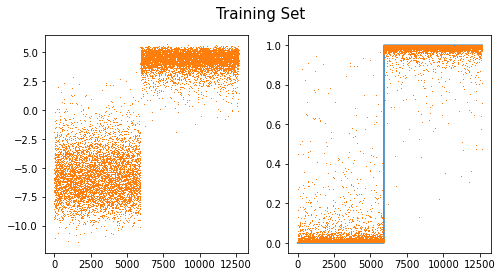

In [70]:
sftmax = torch.nn.Softmax(dim=1) 
sig = torch.nn.Sigmoid()
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(net(X).diff(axis=1).data,',',color="C1") # u2-u1
ax[1].plot(y)
ax[1].plot(sftmax(net(X))[:,1].data,',')
#ax[1].plot(sig(net(X).diff(axis=1)).data,',')
fig.suptitle("Training Set",size=15)

Text(0.5, 0.98, 'Test Set')

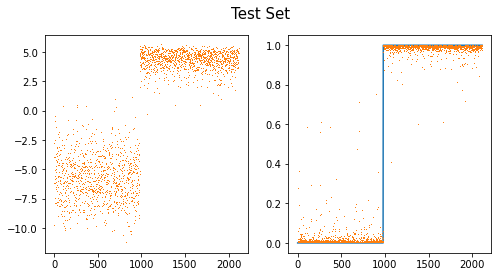

In [71]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(net(XX).diff(axis=1).data,',',color="C1")
ax[1].plot(yy)
ax[1].plot(sftmax(net(XX))[:,1].data,',')
#ax[1].plot(sig(net(XX).diff(axis=1)).data,',')
fig.suptitle("Test Set",size=15)

`-` note: softmax(u1,u2)=[sig(u1-u2), sig(u2-u1)]=[1-sig(u2-u1),sig(u2-u1)]

$\frac{1}{e^{u_1}+e^{u_2}} \to \frac{e^{u_1-u_2}}{e^{u_1-u_2}+e^{u_2-u_2}} \to \frac{e^{u_1-u_2}}{e^{u_1-u_2}+1} \to sig(u_2-u_1)$

### 공부: 이진분류에서 소프트맥스 vs 시그모이드 

`-` 이진분류문제 = "y=0 or y=1" 을 맞추는 문제 = 성공과 실패를 맞추는 문제 = 성공확률과 실패확률을 추정하는 문제 

`-` softmax, sigmoid
- softmax: (실패확률, 성공확률) 꼴로 결과가 나옴 // softmax는 실패확률과 성공확률을 둘다 추정한다. 
- sigmoid: (성공확률) 꼴로 결과가 나옴 // sigmoid는 성공확률만 추정한다. 

`-` 그런데 "실패확률=1-성공확률" 이므로 사실상 둘은 같은걸 추정하는 셈이다. (성공확률만 추정하면 실패확률은 저절로 추정되니까) 

`-` 아래는 사실상 같은 모형이다. 

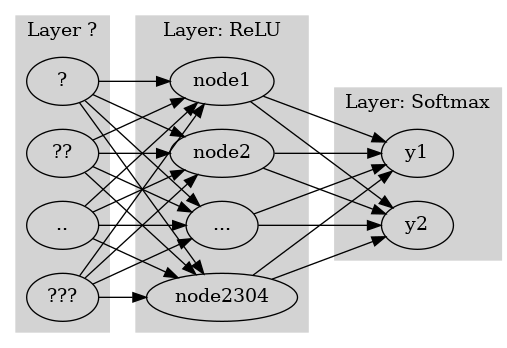

In [72]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "?"
    "??"
    ".."
    "???"
    label = "Layer ?"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "?" -> "node1"
    "??" -> "node1"
    ".." -> "node1"
    "???" -> "node1"
    
    "?" -> "node2"
    "??" -> "node2"
    ".." -> "node2"
    "???" -> "node2"
    
    "?" -> "..."
    "??" -> "..."
    ".." -> "..."
    "???" -> "..."
    
    "?" -> "node2304"
    "??" -> "node2304"
    ".." -> "node2304"
    "???" -> "node2304"

    label = "Layer: ReLU"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y1"
    "node2" -> "y1"
    "..." -> "y1"
    "node2304" -> "y1"
    
    "node1" -> "y2"
    "node2" -> "y2"
    "..." -> "y2"
    "node2304" -> "y2"    
    label = "Layer: Softmax"
}
''')

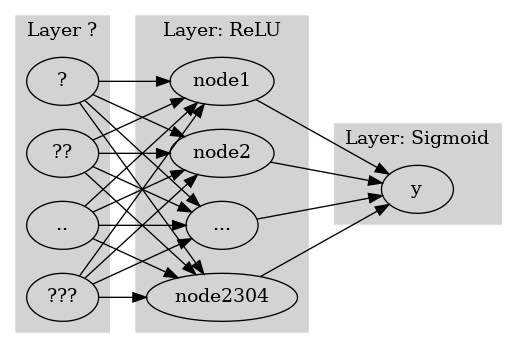

In [73]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "?"
    "??"
    ".."
    "???"
    label = "Layer ?"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "?" -> "node1"
    "??" -> "node1"
    ".." -> "node1"
    "???" -> "node1"
    
    "?" -> "node2"
    "??" -> "node2"
    ".." -> "node2"
    "???" -> "node2"
    
    "?" -> "..."
    "??" -> "..."
    ".." -> "..."
    "???" -> "..."
    
    "?" -> "node2304"
    "??" -> "node2304"
    ".." -> "node2304"
    "???" -> "node2304"

    label = "Layer: ReLU"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y"
    "node2" -> "y"
    "..." -> "y"
    "node2304" -> "y"
    label = "Layer: Sigmoid"
}
''')

`-` 둘은 사실상 같은 효과를 주는 모형인데 학습할 파라메터는 sigmoid의 경우가 더 적다. $\to$ sigmoid를 사용하는 모형이 비용은 싸고(학습할 파라메터가 적음) 효과는 동일하다는 말 $\to$ 이진분류 한정해서는 softmax를 쓰지말고 sigmoid를 써야함. 
- softmax가 갑자기 너무 안좋아보이는데 sigmoid는 k개의 클래스로 확장이 불가능한 반면 softmax는 확장이 용이하다는 장점이 있음 

### 소프트맥스 vs 시그모이드 정리 

`-` 결론 
1. 소프트맥스는 시그모이드의 확장이다. 
2. 클래스의 수가 2개일 경우에는 (Sigmoid, BCEloss) 조합을 사용해야 하고 클래스의 수가 2개보다 클 경우에는 (Softmax, CrossEntropyLoss) 를 사용해야 한다. 


`-` 그런데 사실.. 클래스의 수가 2개일 경우일때 (Softmax, CrossEntropyLoss)를 사용해도 그렇게 큰일나는것은 아니다. (흑백이미지를 칼라잉크로 출력하는 느낌) 

***참고***

|$y$|분포가정|마지막층의 활성화함수|손실함수|
|:--:|:--:|:--:|:--:|
|3.45, 4.43, ... (연속형) |정규분포|None (or Identity)|MSE|
|0 or 1|이항분포 with $n=1$ (=베르누이) |Sigmoid| BCE|
|[0,0,1], [0,1,0], [1,0,0]| 다항분포 with $n=1$|Softmax| Cross Entropy |

## fastai metric 사용 

### 데이터준비

`-` download data 

In [74]:
path = untar_data(URLs.MNIST)

`-` training set 

In [75]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1])/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

`-` test set 

In [76]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
XX = torch.concat([X0,X1])/255
yy = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

In [77]:
X.shape,XX.shape,y.shape,yy.shape

(torch.Size([12665, 1, 28, 28]),
 torch.Size([2115, 1, 28, 28]),
 torch.Size([12665, 1]),
 torch.Size([2115, 1]))

### 사용자정의 메트릭이용 

(1) dls 만들기

In [78]:
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 
dls = DataLoaders(dl1,dl2) 

(2) lrnr 생성 

In [79]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss() 

In [80]:
def acc(yhat,y) : 
    return ((yhat>0.5)==y).float().mean()

In [81]:
def err(yhat,y):
    return 1-((yhat>0.5)==y).float().mean()

In [82]:
lrnr = Learner(dls,net,loss_fn,metrics=[acc,err])

(3) 학습

In [83]:
lrnr.fit(10)

epoch,train_loss,valid_loss,acc,err,time
0,1.012566,0.676096,0.463357,0.536643,00:00
1,0.738655,0.477148,0.994799,0.005201,00:00
2,0.603908,0.335415,0.985816,0.014184,00:00
3,0.497049,0.183633,0.995745,0.004255,00:00
4,0.394664,0.097668,0.995745,0.004255,00:00
5,0.309929,0.056333,0.995745,0.004255,00:00
6,0.244836,0.037147,0.995745,0.004255,00:00
7,0.195441,0.027278,0.995745,0.004255,00:00
8,0.157570,0.021531,0.995745,0.004255,00:00
9,0.128163,0.017795,0.997163,0.002837,00:00


(4) 예측

- 생략

### fastai지원 메트릭이용-- 잘못된사용 

(1) dls 만들기

In [84]:
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 
dls = DataLoaders(dl1,dl2) 

(2) lrnr 생성 

In [85]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
lrnr = Learner(dls,net,loss_fn,metrics=[accuracy,error_rate])

In [86]:
accuracy??

Signature: accuracy(inp, targ, axis=-1)
Source:   
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    return (pred == targ).float().mean()
File:      ~/anaconda3/envs/csy/lib/python3.8/site-packages/fastai/metrics.py
Type:      function


In [87]:
error_rate??

Signature: error_rate(inp, targ, axis=-1)
Source:   
def error_rate(inp, targ, axis=-1):
    "1 - `accuracy`"
    return 1 - accuracy(inp, targ, axis=axis)
File:      ~/anaconda3/envs/csy/lib/python3.8/site-packages/fastai/metrics.py
Type:      function


(3) 학습

In [88]:
lrnr.fit(10)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.971997,0.616424,0.463357,0.536643,00:00
1,0.671642,0.380434,0.463357,0.536643,00:00
2,0.525948,0.232161,0.463357,0.536643,00:00
3,0.414203,0.123899,0.463357,0.536643,00:00
4,0.322394,0.071857,0.463357,0.536643,00:00
5,0.252299,0.045784,0.463357,0.536643,00:00
6,0.199783,0.032276,0.463357,0.536643,00:00
7,0.160118,0.024500,0.463357,0.536643,00:00
8,0.129659,0.019576,0.463357,0.536643,00:00
9,0.105914,0.016207,0.463357,0.536643,00:00


- 이상하다..? 

(4) 예측 

In [89]:
lrnr.model.to("cpu")

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2304, out_features=1, bias=True)
  (5): Sigmoid()
)

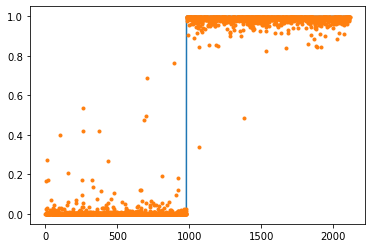

In [90]:
plt.plot(yy)
plt.plot(lrnr.model(XX).data,'.')

- 맞추는건 잘 맞추는데? 

### fastai지원 메트릭이용-- 올바른 사용(1)

`-` 가정
- X의 형태는 (n,채널,픽셀,픽셀)로 가정한다. 
- y의 형태는 (n,) 벡터이다. 즉 $n\times 1$ 이 아니라 그냥 길이가 $n$인 벡터로 가정한다. 
- y의 각 원소는 0,1,2,3,... 와 같이 카테고리를 의미하는 숫자이어야 하며 이 숫자는 int형으로 저장되어야 한다. 
- loss function은 CrossEntropyLoss()를 쓴다고 가정한다. (따라서 네트워크의 최종레이어는 torch.nn.Linear(?,클래스의수) 꼴이 되어야 한다.)

(1) dls 만들기

지원하는 함수로 바꿔주기

In [91]:
y.to(torch.int64).reshape(-1),yy.to(torch.int64).reshape(-1)

(tensor([0, 0, 0,  ..., 1, 1, 1]), tensor([0, 0, 0,  ..., 1, 1, 1]))

In [92]:
ds1 = torch.utils.data.TensorDataset(X,y.to(torch.int64).reshape(-1))
ds2 = torch.utils.data.TensorDataset(XX,yy.to(torch.int64).reshape(-1))
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 
dls = DataLoaders(dl1,dl2) 

(2) lrnr 생성 

In [93]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,2),
)
loss_fn = torch.nn.CrossEntropyLoss()
lrnr = Learner(dls,net,loss_fn,metrics=[accuracy,error_rate])

(3) 학습

In [94]:
lrnr.fit(10)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.038122,0.539247,0.463357,0.536643,00:00
1,0.621439,0.261176,0.977778,0.022222,00:00
2,0.451623,0.118811,0.989125,0.010875,00:00
3,0.333172,0.059299,0.995272,0.004728,00:00
4,0.250918,0.037678,0.996217,0.003783,00:00
5,0.193416,0.026810,0.996217,0.003783,00:00
6,0.152078,0.020631,0.996217,0.003783,00:00
7,0.121511,0.016605,0.996690,0.003310,00:00
8,0.098301,0.013718,0.997636,0.002364,00:00
9,0.080287,0.011546,0.998109,0.001891,00:00


### fastai지원 메트릭이용-- 올바른 사용(2)

`-` 가정 
- X의 형태는 (n,채널,픽셀,픽셀)로 가정한다. 
- y의 형태는 (n,클래스의수)로 가정한다. 즉 y가 one_hot 인코딩된 형태로 가정한다. 
- y의 각 원소는 0 혹은 1이다. 
- loss function은 CrossEntropyLoss()를 쓴다고 가정한다. (따라서 네트워크의 최종레이어는 torch.nn.Linear(?,클래스의수) 꼴이 되어야 한다.)

(1) dls 만들기

In [95]:
y_onehot = torch.tensor(list(map(lambda x: [1.0,0.0] if x==0 else [0.0,1.0], y)))
yy_onehot = torch.tensor(list(map(lambda x: [1.0,0.0] if x==0 else [0.0,1.0], yy)))
# y_onehot = torch.nn.functional.one_hot(y.reshape(-1).to(torch.int64)).to(torch.float32)
# yy_onehot = torch.nn.functional.one_hot(yy.reshape(-1).to(torch.int64)).to(torch.float32)

In [98]:
ds1 = torch.utils.data.TensorDataset(X,y_onehot)
ds2 = torch.utils.data.TensorDataset(XX,yy_onehot)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=1266) 
dl2 = torch.utils.data.DataLoader(ds2,batch_size=2115) 
dls = DataLoaders(dl1,dl2) 

(2) lrnr 생성 

In [100]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,2),
    #torch.nn.Softmax()
)
loss_fn = torch.nn.CrossEntropyLoss() 
lrnr = Learner(dls,net,loss_fn,metrics=[accuracy_multi])

`accuracy_multi` 

(3) 학습

In [101]:
lrnr.fit(10)

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.038750,0.569555,0.463357,00:00
1,0.640057,0.285553,0.977778,00:00
2,0.469265,0.137582,0.987943,00:00
3,0.348698,0.064898,0.995035,00:00
4,0.262547,0.038338,0.996217,00:00
5,0.201805,0.025988,0.996690,00:00
6,0.158089,0.019443,0.996927,00:00
7,0.125811,0.015470,0.997163,00:00
8,0.101381,0.012772,0.998109,00:00
9,0.082515,0.010802,0.998582,00:00
